Original code provided

In [242]:
# -*- coding: utf-8 -*-
"""
A replication of
Chaudhuri, Rishidev, et al.
"A large-scale circuit mechanism for hierarchical dynamical processing in the primate cortex."
Neuron 88.2 (2015): 419-431.
Figure 3A can not be reproduced exactly because the parameters used to generate
the figure in original paper is of higher precision than the parameters reported.
@author: Guangyu Robert Yang, 2015/11; Vishwa Goudar, 2021/11
"""
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import math


class Model(object):
    """
    A model of multiple interacting brain areas from Chaudhuri et al. Neuron 2015
    """
    def __init__(self, datafile='subgraph_data.pkl', seed = 0, ext_params={}):
        #---------------------------------------------------------------------------------
        # Loading Anatomical Data from Kennedy's group
        #---------------------------------------------------------------------------------
        
        try:
            with open(datafile,'rb') as f:
                p = pickle.load(f)
        except UnicodeDecodeError:  # Python 3 compatibility
            with open(datafile,'rb') as f:
                p = pickle.load(f, encoding='latin1')

        print('Initializing Model. From ' + datafile + ' load:')
        print(p.keys())

        ind = 1 # 1=normal, 2=replace by average
        if ind == 1:
            p['hier_vals'] = p['hier_vals']/max(p['hier_vals']) 
        elif ind == 2:
            p['hier_vals'] = np.array([float(np.mean(p['hier_vals'])/max(p['hier_vals'])) for i in range(len(p['hier_vals']))])

        print(type(p['hier_vals']))

        p['n_area'] = len(p['areas'])

        #---------------------------------------------------------------------------------
        # Network Parameters
        #---------------------------------------------------------------------------------

        p['beta_exc'] = 0.064  # Hz/pA
        p['beta_inh'] = 0.351  # Hz/pA
        p['tau_exc'] = 20  # ms
        p['tau_inh'] = 10  # ms
        p['wEE'] = 24.3  # pA/Hz
        p['wIE'] = 12.2  # pA/Hz
        p['wEI'] = 19.7  # pA/Hz
        p['wII'] = 12.5  # pA/Hz
        p['muEE'] = 33.7  # pA/Hz
        p['muIE'] = 25.3  # pA/Hz
        p['eta'] = 0.68
        
        for key, value in ext_params.items():
            p[key] = value

        self.fI = lambda x : x*(x>0) # f-I curve

        p['exc_scale'] = (1+p['eta']*p['hier_vals'])
        self.p = p
        
        # Seed random number generator
        np.random.seed(seed)

    def run_stimulus(self, T = 4000, noise=False, area_act = 'V1', plot_t_interval = None):

        if area_act is not None:
            print('Running network with stimulation to ' + area_act)

        #---------------------------------------------------------------------------------
        # Redefine Parameters
        #---------------------------------------------------------------------------------

        p = self.p

        # Definition of combined parameters

        local_EE = p['beta_exc'] * p['wEE'] * p['exc_scale']
        local_EI = -p['beta_exc'] * p['wEI']
        local_IE =  p['beta_inh'] * p['wIE'] * p['exc_scale']
        local_II = -p['beta_inh'] * p['wII']

        fln_scaled = (p['exc_scale'] * p['fln_mat'].T).T


        #---------------------------------------------------------------------------------
        # Simulation Parameters
        #---------------------------------------------------------------------------------

        dt = 0.2   # ms
        t_plot = np.linspace(0, T, int(T/dt)+1)
        n_t = len(t_plot)

        # From target background firing inverts background inputs
        r_exc_tgt = 10 * np.ones(p['n_area'])
        r_inh_tgt = 35 * np.ones(p['n_area'])

        longrange_E = np.dot(fln_scaled,r_exc_tgt)
        I_bkg_exc = r_exc_tgt - (local_EE*r_exc_tgt + local_EI*r_inh_tgt
                                 + p['beta_exc']*p['muEE']*longrange_E)
        I_bkg_inh = r_inh_tgt - (local_IE*r_exc_tgt + local_II*r_inh_tgt
                                 + p['beta_inh']*p['muIE']*longrange_E)

        # Set stimulus input
        I_stim_exc = np.zeros((n_t,p['n_area']))

        if noise: # All areas receive equal noise
            I_stim_exc = (41.8646/100.0)*(2.0 + 0.5*np.random.rand(n_t, p['n_area']))

        if area_act is not None: # Stimulate specific area
            area_stim_idx = p['areas'].index(area_act) # Index of stimulated area
            time_idx = (t_plot>100) & (t_plot<=350)
            I_stim_exc[time_idx, area_stim_idx] += 41.8646
            # Above value chosen so that V1 is driven up to 100 Hz

        #---------------------------------------------------------------------------------
        # Storage
        #---------------------------------------------------------------------------------

        r_exc = np.zeros((n_t,p['n_area']))
        r_inh = np.zeros((n_t,p['n_area']))

        #---------------------------------------------------------------------------------
        # Initialization
        #---------------------------------------------------------------------------------

        # Set activity to background firing
        r_exc[0] = r_exc_tgt
        r_inh[0] = r_inh_tgt

        #---------------------------------------------------------------------------------
        # Running the network
        #---------------------------------------------------------------------------------

        for i_t in range(1, n_t):
            longrange_E = np.dot(fln_scaled,r_exc[i_t-1])
            I_exc = (local_EE*r_exc[i_t-1] + local_EI*r_inh[i_t-1] +
                     p['beta_exc'] * p['muEE'] * longrange_E +
                     I_bkg_exc + I_stim_exc[i_t])

            I_inh = (local_IE*r_exc[i_t-1] + local_II*r_inh[i_t-1] +
                     p['beta_inh'] * p['muIE'] * longrange_E + I_bkg_inh)

            d_r_exc = -r_exc[i_t-1] + self.fI(I_exc)
            d_r_inh = -r_inh[i_t-1] + self.fI(I_inh)

            r_exc[i_t] = r_exc[i_t-1] + d_r_exc * dt/p['tau_exc']
            r_inh[i_t] = r_inh[i_t-1] + d_r_inh * dt/p['tau_inh']

        #---------------------------------------------------------------------------------
        # Plotting the results
        #---------------------------------------------------------------------------------

        _ = plt.figure(figsize=(5,10))
        if area_act != 'V1':
            area_name_list = ['2','5','F1','10','9/46v','9/46d','F5','7B','F2','ProM','F7','8B','24c']
        else:
            area_name_list = ['V1','V4','8m','8l','TEO','7A','9/46d','TEpd','24c']
        if area_act is not None:
            area_idx_list = [-1]+[p['areas'].index(name) for name in area_name_list]
        else:
            area_idx_list = [p['areas'].index(name) for name in area_name_list]
        f, ax_list = plt.subplots(len(area_idx_list), sharex=True)
        if plot_t_interval is not None:
            plot_t_interval = np.rint(np.array(plot_t_interval)/dt).astype(int)

        for ax, area_idx in zip(ax_list, area_idx_list):
            if area_idx < 0:
                y_plot = I_stim_exc[:, area_stim_idx]
                txt = 'Input'
            else:
                y_plot = r_exc[:,area_idx]
                txt = p['areas'][area_idx]

            y_plot = y_plot - y_plot.min()
            if plot_t_interval is None:
                ax.plot(t_plot, y_plot)
                ax.set_ylim(y_plot.min(),y_plot.max())
                ax.set_yticks([y_plot.max()])
                ax.set_yticklabels(['{:0.4f}'.format(y_plot.max())])
            else:
                ax.plot(t_plot[plot_t_interval[0]:plot_t_interval[1]], y_plot[plot_t_interval[0]:plot_t_interval[1]])
                ax.set_ylim(y_plot[plot_t_interval[0]:plot_t_interval[1]].min(),y_plot[plot_t_interval[0]:plot_t_interval[1]].max())
                ax.set_yticks([y_plot[plot_t_interval[0]:plot_t_interval[1]].max()])
                ax.set_yticklabels(['{:0.4f}'.format(y_plot[plot_t_interval[0]:plot_t_interval[1]].max())])

            ax.text(0.9, 0.6, txt, transform=ax.transAxes)
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')

        f.text(-0.01, 0.5, 'Change in firing rate (Hz)', va='center', rotation='vertical')
        ax.set_xlabel('Time (ms)')

        self.dt = dt
        self.r_exc = r_exc
        self.I_stim_exc = I_stim_exc

        
    # Calculate autocorrelation fn (ACF) based on firing rates during t_interval; acf_length specifices lag of ACF
    def calculate_acf(self, t_interval = None, acf_length = 1000, plot = True):
        #---------------------------------------------------------------------------------
        # Transforming to time steps
        #---------------------------------------------------------------------------------
        t_interval = np.rint(np.array(t_interval)/self.dt).astype(int)
        acf_length = np.rint(np.array(acf_length)/self.dt).astype(int)
        step = np.rint(1.0/self.dt).astype(int)

        #---------------------------------------------------------------------------------
        # Computing ACF
        #---------------------------------------------------------------------------------
        print('Computing ACF. Depending on the lag, this will take some time ...')
        x = self.r_exc[t_interval[0]:t_interval[1],:]
        acf = []
        for i in range(1, acf_length, step):
            X = x[:-i, :]
            Xt = x[i:, :]
            Xm = np.mean(X, axis=0)
            Xtm = np.mean(Xt, axis=0)
            acf.append(np.mean((X-Xm)*(Xt-Xtm), axis=0)/np.mean((X-Xm)**2, axis=0))
            
        self.acf = np.concatenate((np.ones((1,self.r_exc.shape[1])), np.array(acf)), axis=0).T

        #---------------------------------------------------------------------------------
        # Plotting the results
        #---------------------------------------------------------------------------------
        if plot:            
            area_name_list = ['V1','V4','8m','8l','TEO','2','7A','10','9/46v','9/46d','TEpd','7m','7B','24c']
            # area_name_list = ['5','2','F1','10','9/46v','9/46d','F5','7B','F2','ProM','F7','8B','24c']  
            cs = ['darkviolet','mediumorchid','thistle','navy','royalblue','lightsteelblue','forestgreen','limegreen','greenyellow','yellow','gold','orange','darkorange','orangered']
            area_idx_list = [self.p['areas'].index(name) for name in area_name_list]

            ax = plt.subplot()
            for i, area_idx in enumerate(area_idx_list):
                y_plot = self.acf[area_idx, :] 
                y_plot = y_plot
                txt = self.p['areas'][area_idx]

                ax.plot(range(y_plot.shape[0]), y_plot,label=txt,color=cs[i])

            ax.set_yticks([0,1])
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            plt.xlim([0, self.acf.shape[1]])
            plt.ylim([-0.075,1])
            ax.set_xlabel('Time Difference (ms)')
            ax.set_ylabel('Autocorrelation Function')
            plt.legend(fontsize='x-small', ncol=2)


    # Fit exponential curves to ACF and extract time constants
    def compute_time_constants(self, plot = True, myplot = True):
        assert(hasattr(self, 'acf'))

        # Helper function to calculate sum of squared error
        def sse(y_hat, y):
            return np.sum((y_hat-y)**2)
        
        if plot:
            f, ax_list = plt.subplots(self.acf.shape[0],1, sharex='col')            
            
        #---------------------------------------------------------------------------------
        # Fitting exponential and getting time constants
        #---------------------------------------------------------------------------------
        tc = []
        x = np.arange(self.acf.shape[1])*0.001

        plt.figure()
        tau_k_lst = []

        for i in range(self.acf.shape[0]):
            acf = np.squeeze(self.acf[i, :])
            if np.sum(acf < 0.05) > 0:
                t = np.argwhere(acf < 0.05)[0]
            else:
                t = acf.shape
            px, pc = curve_fit(lambda t,a,b: a*np.exp(b*t),  x[:t[0]], acf[:t[0]], p0=[0.5,-1], bounds = ([0.0,-50], [1.0,-1]), maxfev=100000,ftol=1.49012e-15, xtol=1.49012e-15)
            px2, pc2 = curve_fit(lambda t,a,b,d: a*np.exp(b*t) + (1.0-a)*np.exp(d*t),  x[:t[0]], acf[:t[0]], p0=[0.5,-1,-50], bounds = ([0.0,-50,-50], [1.0,-1,-1]), maxfev=100000,ftol=1.49012e-15, xtol=1.49012e-15)
            
            # Get time constants
            if sse(px[0]*np.exp(px[1]*x[:t[0]]), acf[:t[0]]) < 8.0*sse(px2[0]*np.exp(px2[1]*x[:t[0]]) + (1.0-px2[0])*np.exp(px2[2]*x[:t[0]]), acf[:t[0]]):
                tc.append(-1000.0/px[1])
                y_targ = px[0]*np.exp(px[1]*x)
                tau_k = -1/px[1]
            else:
                tc.append(px2[0]*(-1000.0/px2[1]) + (1.0-px2[0])*(-1000.0/px2[2]))
                y_targ = px2[0]*np.exp(px2[1]*x) + (1.0-px2[0])*np.exp(px2[2]*x)
                tau_k1 = -1/px2[1]
                tau_k2 = -1/px2[2]
                w_k1 = px2[0]
                w_k2 = 1.0-px2[0]
                tau_k = w_k1*tau_k1+w_k2*tau_k2
            tau_k_lst.append(tau_k)
        
        area_name_list = ['V1','V4','8m','8l','TEO','2','7A','10','9/46v','9/46d','TEpd','7m','7B','24c']
        cs = ['darkviolet','mediumorchid','thistle','navy','royalblue','lightsteelblue','forestgreen','limegreen','greenyellow','yellow','gold','orange','darkorange','orangered']
        for i in range(len(area_name_list)):
            plt.bar(i,tau_k_lst[i],label=area_name_list[i],color=cs[i])
        # plt.title('The dominant time constants in various areas of the network, \n extracted by fitting exponentials to the autocorrelation.')
        plt.ylabel('T_fitted')
        plt.legend()
        print(min(tau_k_lst[0:14]),max(tau_k_lst[0:14]))

        self.tc = tc

                        
    # Calculate functional connectivity (FC) based on firing rates during t_interval
    def calculate_fc(self, t_interval = None, plot = True):
        #---------------------------------------------------------------------------------
        # Transforming to time steps
        #---------------------------------------------------------------------------------
        t_interval = np.rint(np.array(t_interval)/self.dt).astype(int)
        
        
        #---------------------------------------------------------------------------------
        # Computing FC
        #---------------------------------------------------------------------------------
        x = self.r_exc[t_interval[0]:t_interval[1],:]
        fc = np.corrcoef(x.T)
        self.fc = fc
    
        #---------------------------------------------------------------------------------
        # Plotting the results
        #---------------------------------------------------------------------------------
        if plot:
            ax = plt.subplot()
            im = ax.imshow(fc,  extent = [0, fc.shape[0], 0, fc.shape[1]],origin='upper')
            im.set_clim([0,0.3])
            ax.set_xticks([i for i in range(0, fc.shape[0], 2)])
            ax.set_xticklabels(self.p['areas'][0:fc.shape[0]:2],rotation = 45)
            plt.setp(ax.get_xticklabels(), fontsize=8)
            ax.set_yticks([i for i in range(1, fc.shape[0], 2)])
            rlab = self.p['areas'][1:fc.shape[0]:2]
            ax.set_yticklabels(rlab[::-1])
            plt.setp(ax.get_yticklabels(), fontsize=8)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            plt.show()


Initializing Model. From subgraph_data.pkl load:
dict_keys(['fln_mat', 'sln_mat', 'hier_vals', 'areas'])
<class 'numpy.ndarray'>
Running network with stimulation to V1


<Figure size 500x1000 with 0 Axes>

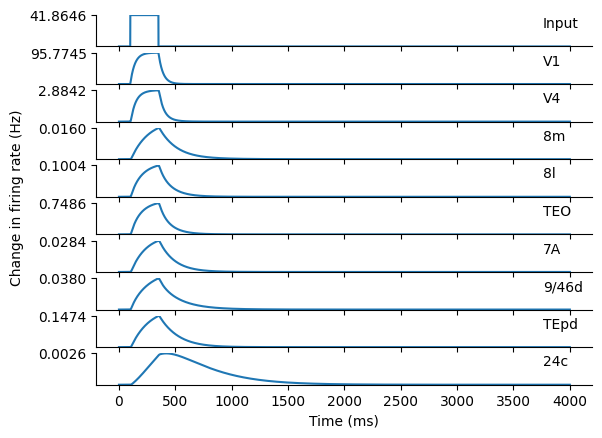

In [243]:
mm = Model()
mm.run_stimulus(plot_t_interval=None)

Computing ACF. Depending on the lag, this will take some time ...


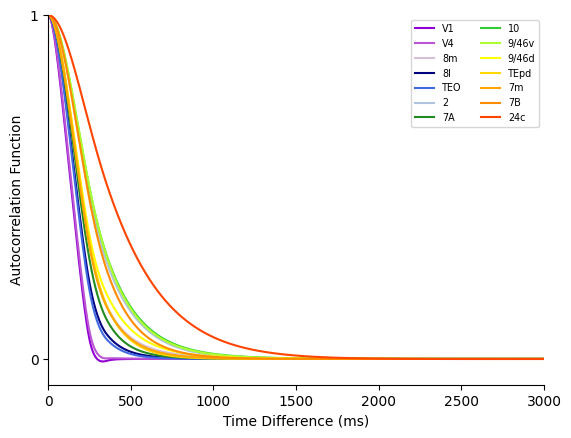

In [244]:
mm.calculate_acf(t_interval=[0,4000],acf_length=3000)

0.17548140971065265 0.37567230210945163


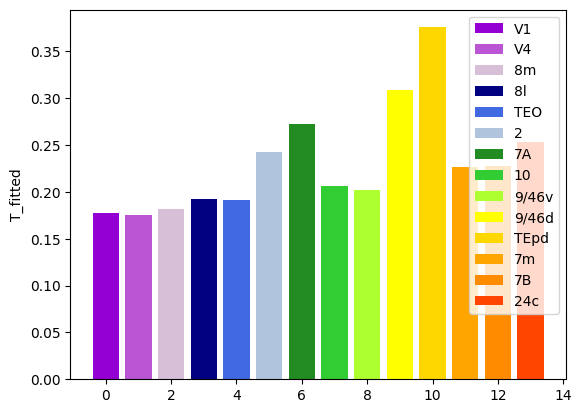

In [245]:
mm.compute_time_constants(plot=None,myplot=True)